# 2023 NFL Touchdown Regression

Siddarth Puliyanda

I will be using the 2022 NFL Player stats to see if a player scored more or less touchdowns than expected in the 2022 season.
This can help determine who overperformed or underperformed in the touchdown category for 2021 and if a player is due for a positive or negative touchdown regression for the 2023 season.

The method of analysis will be to find the average amount of touchdowns (TDs) scored for each position in 2022 and compare that to the actual amount of TDs they scored, based on that player's skill position stat (passing attempts, rushing attempts, or receptions). This is essentially expected - observed, or the residual.

The data was pulled from https://www.pro-football-reference.com/years/2022/fantasy.htm

This is a continuation of my yearly Touchdown Regression Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Import and read in data, and view the column names
df = pd.read_excel('2022_Fantasy_Stats.xlsx')[0:151] #Top 150 scoring players
display(df.head())
print(df.columns)

/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,FL,TD.3,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1.0,Patrick Mahomes*+,KAN,QB,27.0,17.0,17.0,435.0,648.0,5250.0,...,0.0,4.0,2.0,416.0,417.4,435.4,428.9,136.0,1.0,1.0
1,2.0,Josh Jacobs*+,LVR,RB,24.0,17.0,17.0,0.0,0.0,0.0,...,1.0,12.0,NaN,275.0,328.3,335.3,301.8,127.0,1.0,2.0
2,3.0,Christian McCaffrey*,2TM,RB,26.0,17.0,16.0,1.0,1.0,34.0,...,0.0,13.0,NaN,271.0,356.4,362.4,313.9,123.0,2.0,3.0
3,4.0,Derrick Henry *,TEN,RB,28.0,16.0,16.0,2.0,2.0,4.0,...,3.0,13.0,NaN,270.0,302.8,311.8,286.3,122.0,3.0,4.0
4,5.0,Justin Jefferson*+,MIN,WR,23.0,17.0,17.0,2.0,2.0,34.0,...,0.0,9.0,NaN,241.0,368.7,371.7,304.7,119.0,1.0,5.0


Index(['Rk', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Yds',
       'TD', 'Int', 'Att.1', 'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2',
       'Y/R', 'TD.2', 'Fmb', 'FL', 'TD.3', '2PP', 'FantPt', 'PPR', 'DKPt',
       'FDPt', 'VBD', 'PosRank', 'OvRank'],
      dtype='object')


We only want to see the top 150 scoring fantasy players from 2022 because players after that are quite irrelevant. Also all players who are top 150 scorers probably played more than 5 games, which is a decent amount of games per player given there's only 17 games in a season.

## Clean and Prep Data

In [2]:
#We can see that Attempts, Yards, and TDs have duplicative column names
#Let's rename some of the columns for simplicity
df = df.rename(columns={'Att':'Pass_Atts','Yds':'Pass_Yds','TD':'Pass_TD',
                        'Att.1':'Rush_Att','Yds.1':'Rush_Yds','TD.1':'Rush_TD',
                        'Yds.2':'Yds','TD.2':'Receive_TD','TD.3':'Total_TD'})
df.columns

Index(['Rk', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Pass_Atts',
       'Pass_Yds', 'Pass_TD', 'Int', 'Rush_Att', 'Rush_Yds', 'Y/A', 'Rush_TD',
       'Tgt', 'Rec', 'Yds', 'Y/R', 'Receive_TD', 'Fmb', 'FL', 'Total_TD',
       '2PP', 'FantPt', 'PPR', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank'],
      dtype='object')

In [3]:
#Confirm that all players played at least 5 games
print(df.sort_values(by = ['G'], inplace = False).head(10))

#Some players have FantPos NaN (like Alex Armah), but they will get filtered out later when we create positional dfs

        Rk            Player   Tm FantPos   Age    G   GS    Cmp  Pass_Atts  \
75    76.0        Alex Armah  WAS     NaN  28.0  2.0  0.0    0.0        0.0   
142  143.0    Deshaun Watson  CLE      QB  27.0  6.0  6.0   99.0      170.0   
141  142.0       Sam Darnold  CAR      QB  25.0  6.0  6.0   82.0      140.0   
130  131.0       Breece Hall  NYJ      RB  21.0  7.0  2.0    0.0        0.0   
112  113.0      Carson Wentz  WAS      QB  30.0  8.0  7.0  172.0      276.0   
74    75.0       Tory Carter  TEN     NaN  23.0  9.0  3.0    0.0        0.0   
57    58.0       Cooper Kupp  LAR      WR  29.0  9.0  9.0    0.0        1.0   
118  119.0  Matthew Stafford  LAR      QB  34.0  9.0  9.0  206.0      303.0   
122  123.0       Brock Purdy  SFO      QB  23.0  9.0  5.0  114.0      170.0   
126  127.0       Zach Wilson  NYJ      QB  23.0  9.0  9.0  132.0      242.0   

     Pass_Yds  ...   FL  Total_TD  2PP  FantPt    PPR   DKPt   FDPt   VBD  \
75        0.0  ...  0.0       0.0  NaN     NaN    NaN

In [4]:
# Some player names have characters at the end that we don't need (the * and +). Let's remove them.
df['Player'] = df['Player'].str.replace('*','')
df['Player'] = df['Player'].str.replace('+','')
print(df['Player'].head(10))

0        Patrick Mahomes
1            Josh Jacobs
2    Christian McCaffrey
3         Derrick Henry 
4       Justin Jefferson
5          Austin Ekeler
6             Josh Allen
7           Travis Kelce
8          Davante Adams
9             Nick Chubb
Name: Player, dtype: object


/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_26165/2754416600.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('*','')
/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_26165/2754416600.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('+','')


Let's now create new dataframes for each position, only using the necessary statistical columns for each.
The positions will be: Quarterback (QB), Running Back (RB), Wide Receiver (WR), and Tight End (TE).

In [5]:
# Dataframe for Quarterbacks with passing stats
# Only return top 30 because we don't want QBs who barely played to affect the totals
df_qb = df[['Player','Tm','FantPos','Cmp','Pass_Atts','Pass_Yds','Pass_TD','Total_TD','FantPt','PosRank']]
df_qb = df_qb.loc[df_qb['FantPos'] == 'QB'][:30].reset_index(drop=True)
display(df_qb.head())
display(df_qb.tail())

,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,Total_TD,FantPt,PosRank
0,Patrick Mahomes,KAN,QB,435.0,648.0,5250.0,41.0,4.0,416.0,1.0
1,Josh Allen,BUF,QB,359.0,567.0,4283.0,35.0,7.0,396.0,2.0
2,Jalen Hurts,PHI,QB,306.0,460.0,3701.0,22.0,13.0,378.0,3.0
3,Joe Burrow,CIN,QB,414.0,606.0,4475.0,35.0,5.0,351.0,4.0
4,Geno Smith,SEA,QB,399.0,572.0,4282.0,30.0,1.0,304.0,5.0


,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,Total_TD,FantPt,PosRank
25,Ryan Tannehill,TEN,QB,212.0,325.0,2536.0,13.0,2.0,161.0,26.0
26,Matt Ryan,IND,QB,309.0,461.0,3057.0,14.0,1.0,155.0,27.0
27,Kenny Pickett,PIT,QB,245.0,389.0,2404.0,7.0,3.0,150.0,28.0
28,Baker Mayfield,2TM,QB,201.0,335.0,2163.0,10.0,1.0,121.0,29.0
29,Taylor Heinicke,WAS,QB,161.0,259.0,1859.0,12.0,1.0,116.0,30.0


One thing to note is that QBs could also have positive or negative regression for their rushing TDs. However there
are not enough rushing QBs in the league to make a fair assessment on regression.
Here's the QBs sorted by number of rushing TDs. Only 4 QBs had over 5 rushing TDs and a majority had 2 or less.
So we will ignore rushing TD regression for QBs.

In [6]:
display(df_qb[['Player','Tm','FantPos','Total_TD']].sort_values('Total_TD', ascending = False).reset_index(drop = True))

,Player,Tm,FantPos,Total_TD
0,Jalen Hurts,PHI,QB,13.0
1,Justin Fields,CHI,QB,8.0
2,Daniel Jones,NYG,QB,7.0
3,Josh Allen,BUF,QB,7.0
4,Joe Burrow,CIN,QB,5.0
5,Trevor Lawrence,JAX,QB,5.0
6,Patrick Mahomes,KAN,QB,4.0
7,Marcus Mariota,ATL,QB,4.0
8,Lamar Jackson,BAL,QB,3.0
9,Kenny Pickett,PIT,QB,3.0


In [7]:
#Dataframe for Running Backs with rushing stats
df_rb = df[['Player','Tm','FantPos','Rush_Att','Rush_Yds','Rush_TD','FantPt','PosRank']]
df_rb = df_rb.loc[df_rb['FantPos'] == 'RB'].reset_index(drop=True)
df_rb.head()

,Player,Tm,FantPos,Rush_Att,Rush_Yds,Rush_TD,FantPt,PosRank
0,Josh Jacobs,LVR,RB,340.0,1653.0,12.0,275.0,1.0
1,Christian McCaffrey,2TM,RB,244.0,1139.0,8.0,271.0,2.0
2,Derrick Henry,TEN,RB,349.0,1538.0,13.0,270.0,3.0
3,Austin Ekeler,LAC,RB,204.0,915.0,13.0,266.0,4.0
4,Nick Chubb,CLE,RB,302.0,1525.0,12.0,254.0,5.0


In [8]:
#Dataframe for Wide Receivers with receiving stats
df_wr = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_wr = df_wr.loc[df_wr['FantPos'] == 'WR'].reset_index(drop=True)
df_wr.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,Justin Jefferson,MIN,WR,184.0,128.0,1809.0,8.0,241.0,1.0
1,Davante Adams,LVR,WR,180.0,100.0,1516.0,14.0,236.0,2.0
2,Tyreek Hill,MIA,WR,170.0,119.0,1710.0,7.0,228.0,3.0
3,A.J. Brown,PHI,WR,145.0,88.0,1496.0,11.0,212.0,4.0
4,Stefon Diggs,BUF,WR,154.0,108.0,1429.0,11.0,209.0,5.0


In [9]:
#Dataframe for Tight Ends with receiving stats
df_te = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_te = df_te.loc[df_te['FantPos'] == 'TE'].reset_index(drop=True)
df_te.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,Travis Kelce,KAN,TE,152.0,110.0,1338.0,12.0,206.0,1.0
1,George Kittle,SFO,TE,86.0,60.0,765.0,11.0,141.0,2.0
2,Taysom Hill,NOR,TE,13.0,9.0,77.0,2.0,137.0,3.0
3,T.J. Hockenson,2TM,TE,129.0,86.0,914.0,6.0,129.0,4.0
4,Mark Andrews,BAL,TE,113.0,73.0,847.0,5.0,118.0,5.0


## Analysis

Now that we have all the dataframes for each position, let's create a function that takes a dataframe, finds the average TDs per significant stat (completions for QBs, rush attempts for RBs, or receptions for WRs or TEs), and returns a new dataframe with how much more or less points the player should have scored for the season.

I will create residual plots for given stat (pass attempt, rush attempt, reception) vs. residual (expected - observed). Players below the line overperformed in the touchdown category (and might be due for negative regression) and players above the line underperformed (and might be due for positive regression).

In [10]:
#Create function that can take any skill position's dataframe
#Note: 1 touchdown = 6 fantasy points, but 1 passing touchdown = 4 fantasy points

def avg_x_to_td(df): # x represents either pass attempts, rush attempts, or receptions based on the position
    dfnew = df.copy()
    avg_att = dfnew['Pass/Rush/Reception'].mean() #Find average number of input stat per position
    avg_td = dfnew['TD_Edit'].mean() #Find average number of TDs per position
    avg_att_to_td = avg_att/avg_td #Find average stat to TD ratio per position
    dfnew['Expected_TD'] = dfnew['Pass/Rush/Reception']/avg_att_to_td #New column for expected number of TDs in 2022
    dfnew['TD_diff'] = dfnew['Expected_TD']-dfnew['TD_Edit'] #New column for expected - observed TDs scored in 2022
    if (df['FantPos'] == 'QB').all(): #If player is QB passing TDs are 4 points, other positions TDs are 6 points
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*4        
    else:    
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*6
    dfnew['2022_New'] = dfnew['FantPt_+/-'] + dfnew['FantPt'] #Create column for expected 2022 points
    dfnew = dfnew.sort_values('FantPt_+/-', ascending = False)
    dfnew = dfnew[['PosRank','Player','Tm','FantPos','Pass/Rush/Reception','FantPt','FantPt_+/-','2022_New']].reset_index(drop = True)
    dfnew = dfnew.rename(columns = {'PosRank':'2022 Rank'}) #Observed 2021 rank that we can compare to our expected
    return dfnew

This is a general function we can use for all position, but we must rename the columns for each dataframe so they can be input into the function.

In [11]:
#Rename the columns for each position dataframe
#Create new variables for each edit so that the original dataframes aren't affected
df_qb_edit = df_qb.rename(columns = {'Pass_Atts':'Pass/Rush/Reception', 'Pass_TD': 'TD_Edit'})
df_rb_edit = df_rb.rename(columns = {'Rush_Att':'Pass/Rush/Reception', 'Rush_TD': 'TD_Edit'})
df_wr_edit = df_wr.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})
df_te_edit = df_te.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})

Now let's run the function against each position's dataframe.
We can use the data in the 'FantPt_+/-' column to make predictions about the player's 2023 performance. If their
value is high and positive they are due for a positive TD regression, and the opposite if the value is negative.

In [12]:
#Quarterbacks
qb_new = avg_x_to_td(df_qb_edit)
qb_new

,2022 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2022_New
0,28.0,Kenny Pickett,PIT,QB,389.0,150.0,41.162980,191.162980
1,12.0,Tom Brady,TAM,QB,733.0,272.0,30.325102,302.325102
2,27.0,Matt Ryan,IND,QB,461.0,155.0,25.964355,180.964355
3,11.0,Justin Herbert,LAC,QB,699.0,279.0,24.280009,303.280009
4,9.0,Daniel Jones,NYG,QB,472.0,289.0,23.920120,312.920120
5,23.0,Mac Jones,NWE,QB,442.0,170.0,22.586214,192.586214
6,16.0,Russell Wilson,DEN,QB,483.0,225.0,21.875886,246.875886
7,29.0,Baker Mayfield,2TM,QB,335.0,121.0,19.561950,140.561950
8,24.0,Jacoby Brissett,CLE,QB,369.0,169.0,17.607043,186.607043
9,21.0,Davis Mills,HOU,QB,479.0,182.0,17.164698,199.164698


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


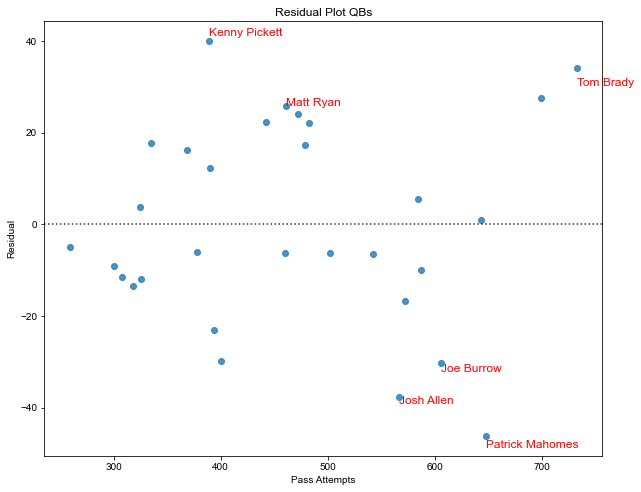

In [13]:
#Plot top and bottom 3 Quarterback names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Patrick Mahomes', 'Josh Allen', 'Kenny Pickett', 'Joe Burrow', 'Tom Brady','Matt Ryan']
for player_name in notable_players:    
    player = qb_new.loc[qb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(qb_new['Pass/Rush/Reception'], qb_new['FantPt_+/-'])
plt.title('Residual Plot QBs')
plt.xlabel('Pass Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
- Kenny Pickett is at the top of the list. He is probably due for a positive passing TD regression since in 2022 he threw less TDs per pass attempts than the league average. This makes sense because he is a rookie and probably adjusting to the NFL level. Last year Trevor Lawrence was at the top of the list and ended up finishing as QB7 this year.
- It might be hard to trust the negative TD regression fully for quarterbacks at the bottom of the list, because some are known to throw lots of touchdowns every season, like Patrick Mahomes, Josh Allen, and Joe Burrow, and we can assume they will continue to do so in the future.
- There are a lot of QB moves expected this year (Aaron Rodgers/Derek Carr new teams, Tom Brady retiring), so we will have to see what every team's final roster looks like at the start of the season.

In [14]:
#Running Backs
rb_new = (avg_x_to_td(df_rb_edit))
rb_new

,2022 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2022_New
0,18.0,Alvin Kamara,NOR,RB,223.0,155.0,30.088899,185.088899
1,11.0,Aaron Jones,GNB,RB,213.0,190.0,28.201504,218.201504
2,39.0,Brian Robinson Jr.,WAS,RB,205.0,104.0,26.691589,130.691589
3,22.0,Tyler Allgeier,ATL,RB,210.0,143.0,21.635286,164.635286
4,42.0,Rachaad White,TAM,RB,129.0,89.0,18.347390,107.347390
5,20.0,Leonard Fournette,TAM,RB,189.0,153.0,17.671757,170.671757
6,29.0,Dameon Pierce,HOU,RB,220.0,136.0,17.522681,153.522681
7,27.0,Raheem Mostert,MIA,RB,181.0,137.0,16.161842,153.161842
8,36.0,Jonathan Taylor,IND,RB,192.0,118.0,12.237976,130.237976
9,16.0,Travis Etienne,JAX,RB,220.0,170.0,11.522681,181.522681


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


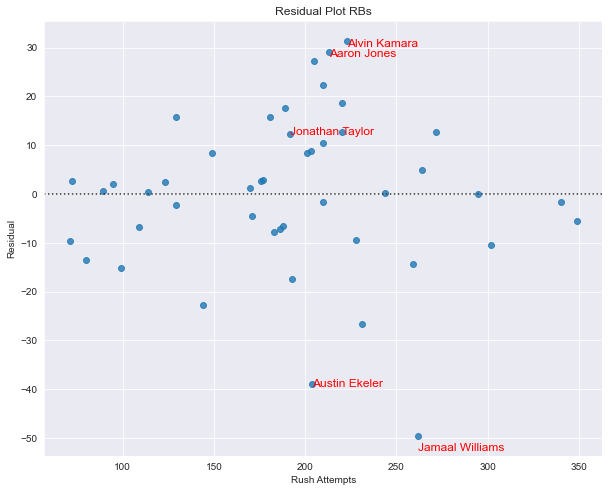

In [15]:
#Plot top and bottom 3 Running Back names on residual plot
#Create scatter plot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Jamaal Williams', 'Alvin Kamara', 'Aaron Jones', 'Austin Ekeler', 'Jonathan Taylor']
for player_name in notable_players:    
    player = rb_new.loc[rb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(rb_new['Pass/Rush/Reception'], rb_new['FantPt_+/-'], ax=ax)
plt.title('Residual Plot RBs')
plt.xlabel('Rush Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
- Alvin Kamara is at the top of the list, but he might end up getting suspended next season. If he does play, it would be good to see who is QB is because the team was not great last year.
- At the very bottom of the list, we have Jamaal Williams. Although he scored much more TDs than expected in 2022, he may continue to see this high volume of TDs because he is the clear Lions goal line back, and the Lions were at the top of the league in points scored last year.
- It's worth noting that a majority of the players at the top of the list for RBs have another major RB on the team that take away touches (Aaron Jones/AJ Dillon, Brian Robinson/Antonio Gibson, Rachaad White/Leonard Fournette), so unless they can get more touches their numbers may not show positive TD regression for next year.

In [16]:
#Wide Receivers
wr_new = (avg_x_to_td(df_wr_edit))
wr_new

,2022 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2022_New
0,46.0,Diontae Johnson,PIT,WR,86.0,95.0,38.696629,133.696629
1,26.0,Chris Godwin,TAM,WR,104.0,119.0,28.795924,147.795924
2,27.0,Michael Pittman Jr.,IND,WR,99.0,118.0,20.546120,138.546120
3,37.0,JuJu Smith-Schuster,KAN,WR,78.0,107.0,17.096943,124.096943
4,45.0,Courtland Sutton,DEN,WR,64.0,95.0,16.797492,111.797492
5,41.0,Josh Palmer,LAC,WR,72.0,97.0,14.397178,111.397178
6,21.0,Garrett Wilson,NYJ,WR,83.0,133.0,13.346747,146.346747
7,33.0,Deebo Samuel,SFO,WR,56.0,112.0,13.197805,125.197805
8,47.0,Marquise Brown,ARI,WR,67.0,89.0,12.147374,101.147374
9,9.0,Amon-Ra St. Brown,DET,WR,106.0,162.0,11.695845,173.695845


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


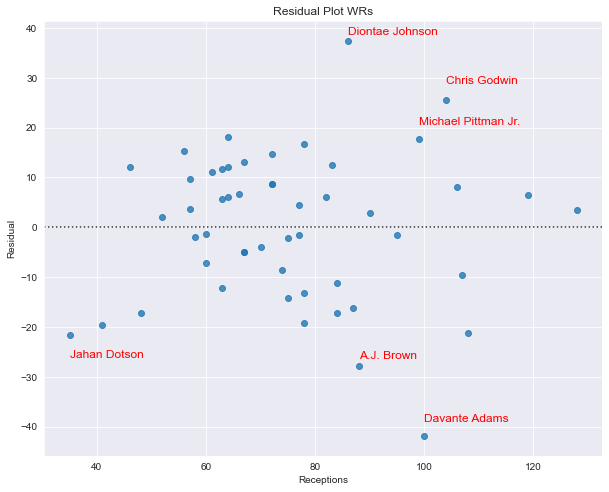

In [17]:
#Plot top and bottom 3 Wide Receiver names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Davante Adams','A.J. Brown','Jahan Dotson','Diontae Johnson',"Chris Godwin",'Michael Pittman Jr.']
for player_name in notable_players:    
    player = wr_new.loc[wr_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(wr_new['Pass/Rush/Reception'], wr_new['FantPt_+/-'])
plt.title('Residual Plot WRs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:

- Wide receivers are interesting because their receiving touchdowns are directly affected by the QB who is throwing the ball. For example, we have Diontae Johnson on the top of the list. His QB situation for the 2022 was rocky, as the Steelers swapped QBs mid-season to rookie Kenny Pickett. If his QB can improve for next season, his TD numbers should improve as well.

- The top 4 receivers on this list all have major question marks heading into next season:
1. Diontae Johnson- competing for targets with the emerging George Pickens. Though we shouldn't expect Johnson to not catch a single TD again, he might still underperform in the category.
2. Chris Godwin- Tom Brady retired so we don't know who the QB will be, but the replacement will not likely be a better player than Brady
3. Michael Pittman Jr.- the Colts are expected to take a QB in the draft, and rookie QBs always come with some question marks
4. Juju Smith-Schuster- was only signed to a 1 year deal with the KC Chiefs, so we will see how his situation ends up.
- On the other end, a lot of the receivers on the bottom of the list also have question marks at QB:
1. Davante Adams- LV Raiders cut Derek Carr; also Adams is 30 years old so we will see if age is a factor for him
2. Jahan Dotson- the Commanders are seemingly starting Sam Howell next season, who has a very small sample size as a starting QB
3. Christian Watson- GB Packers might lose Aaron Rodgers

In [18]:
#Tight Ends
te_new = (avg_x_to_td(df_te_edit))
te_new

,2022 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2022_New
0,12.0,Pat Freiermuth,PIT,TE,63.0,85.0,22.182965,107.182965
1,15.0,Tyler Higbee,LAR,TE,72.0,80.0,21.066246,101.066246
2,6.0,Evan Engram,JAX,TE,73.0,104.0,15.608833,119.608833
3,10.0,Dallas Goedert,PHI,TE,55.0,86.0,11.842271,97.842271
4,4.0,T.J. Hockenson,2TM,TE,86.0,129.0,10.662461,139.662461
5,5.0,Mark Andrews,BAL,TE,73.0,118.0,9.608833,127.608833
6,13.0,David Njoku,CLE,TE,58.0,84.0,7.470032,91.470032
7,14.0,Gerald Everett,LAC,TE,58.0,82.0,7.470032,89.470032
8,11.0,Dalton Schultz,DAL,TE,57.0,86.0,0.927445,86.927445
9,3.0,Taysom Hill,NOR,TE,9.0,137.0,-7.116719,129.883281


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


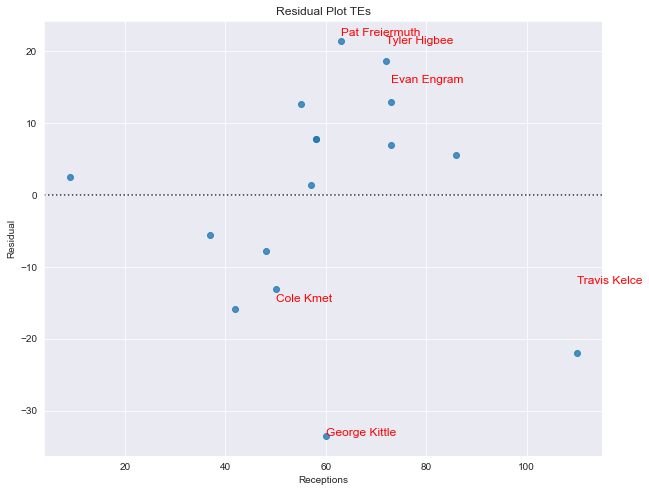

In [19]:
#Plot top and bottom 3 Tight End names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['George Kittle','Travis Kelce','Cole Kmet','Pat Freiermuth','Tyler Higbee','Evan Engram']
for player_name in notable_players:    
    player = te_new.loc[te_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(te_new['Pass/Rush/Reception'], te_new['FantPt_+/-'])
plt.title('Residual Plot TEs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:

- There are only 16 TEs on this list, which makes sense since there are so few good and consistent TEs in the NFL.
- At the top of the list is Pat Freiermuth, who only had 2 TD for his 63 receptions. It should be noted that his QB Kenny Pickett also finished at the top of the QB TD regression list, so both could be slated for some positive TD regression next season.
- At the bottom of the list is George Kittle, who is likely due for a negative TD regression as he scored significantly more TDs than expected in 2021.

## Conclusions

- The TD regression won't tell the full story of how well we think a player will do in 2023 as there are many outside factors that can contribute to success, such as overall talent, trading for/away players, and who each team drafts in the 2023 NFL Draft.

- Some potential correlation can be found with the Pittsburgh Steelers. Kenny Pickett, Diontae Johnson, and Pat Freirmuth all finished at the top of their respective positions for positive TD regression. Pickett didn't begin the year as a starter, but with a full off-season under his belt the offense should be looking to take a step forward. If Pickett can improve from last year, his receivers should get a positive bump as well.

- The model takes into account the number of pass attempts, rushing attempts, and receptions, which is important to include because it can determine a player's usage as well. By looking at the residual plots, we can see how much a player was used in the offense and how their fantasy output might have changed (for better or worse) after applying the touchdown regression. The further a player is away from the middle line of the graph, the more regression they might be due for. Ideally, we would target players that have a high usage.

- If you want to use this data to help with a Fantasy Football Draft in 2023, you can also sort the values in the 2022_New column in descending order to find the expected rankings of each player in 2022. I would likely target players who not only finished high on the rankings in 2022, but are also due for some positive TD regression.

- We will not be able to tell if our conclusions were accurate until the end of the 2023 season, but it will be useful to compare our conclusions to the actual results. Going off of last year, Trevor Lawrence and Miles Sanders both finished at the top of their position lists and ended up showing significant positive regression in the TD category.